0. Import packages.

1. output csv names

2. Get USGS site info and data.

1-1 FIX 13310800 2015

2. Get PRISM data and calculate days_since_october_first and rad_d

3. Merge PRISM and USGS data and check NA

4. Get water year

5. base model and Grid Search CV parameters.

6. evaluation function.

7-0 CREATE AN EMPTY DF

7. create dfs and random forest for each site

8. BIAS PER QUARTILE

9. RM SITE = 0 IN THE DF

10. merge filtered_df (USGS site info and data) AND evaluate_df


12. merge sorted_df and var

0. Import packages. Set modeling periods, months,locations and idv of the data


In [1]:
from dataretrieval import nwis
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf

#!pip uninstall scikit-learn -y
#!pip install scikit-learn 
import sklearn
# Print the version of scikit-learn
print(sklearn.__version__)

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from datetime import datetime
current_time = datetime.now()
print(current_time.strftime("%Y-%m-%d %H:%M:%S"))

startDate   =  "1995-10-01"
endDate     =  "2024-09-30"
model_months=  [6 ,7,8]
model_site  = [
    "13092747"  
              ]
idv         = [ "00060_Mean" ,"tmean" ,"Days_Since_October_1st" ]

1.6.1
2025-05-06 08:49:22


1. output csv names

In [2]:
df_cleaned_csv = "df_cleaned.csv" 
model_df_site_csv ="model_df_site.csv"
sorted_df_csv= "sorted_df.csv"
sorted_df_var_csv ="sorted_df_var.csv"

1. Get USGS site info and data

In [3]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va' 
                   ,   'alt_va'
                  ]
filtered_df = site_info_df[columns_to_save]
#print(filtered_df)

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate) 
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year
dailyStreamtemp_df = dailyStreamtemp_df[ dailyStreamtemp_df['Month'].isin( model_months  )    ]
print( dailyStreamtemp_df.head() )

                     datetime   site_no  00010_Maximum 00010_Maximum_cd  \
244 1996-06-01 00:00:00+00:00  13092747            NaN              NaN   
245 1996-06-02 00:00:00+00:00  13092747            NaN              NaN   
246 1996-06-03 00:00:00+00:00  13092747            NaN              NaN   
247 1996-06-04 00:00:00+00:00  13092747            NaN              NaN   
248 1996-06-05 00:00:00+00:00  13092747            NaN              NaN   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
244            NaN              NaN         NaN           NaN       198.0   
245            NaN              NaN         NaN           NaN       190.0   
246            NaN              NaN         NaN           NaN       192.0   
247            NaN              NaN         NaN           NaN       181.0   
248            NaN              NaN         NaN           NaN       170.0   

    00060_Mean_cd        Date  Month  Year  
244             A  1996-06-01      6  199

2. FIX 13310800 2015

In [4]:
#print( dailyStreamtemp_df[ (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"]== 2015) ] )

#print( dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ] )

dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]

print(dailyStreamtemp_df.head())

                     datetime   site_no  00010_Maximum 00010_Maximum_cd  \
244 1996-06-01 00:00:00+00:00  13092747            NaN              NaN   
245 1996-06-02 00:00:00+00:00  13092747            NaN              NaN   
246 1996-06-03 00:00:00+00:00  13092747            NaN              NaN   
247 1996-06-04 00:00:00+00:00  13092747            NaN              NaN   
248 1996-06-05 00:00:00+00:00  13092747            NaN              NaN   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
244            NaN              NaN         NaN           NaN       198.0   
245            NaN              NaN         NaN           NaN       190.0   
246            NaN              NaN         NaN           NaN       192.0   
247            NaN              NaN         NaN           NaN       181.0   
248            NaN              NaN         NaN           NaN       170.0   

    00060_Mean_cd        Date  Month  Year  
244             A  1996-06-01      6  199

2. Get PRISM data and calculate days_since_october_first and rad_d

In [5]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date']) 
def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days   
    return days_difference if days_difference >= 0 else days_difference + 365
prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)


prism_df['Date'] = prism_df['date'].dt.date
print( prism_df)
#print( prism_df.dtypes )
#print(  prism_df["site_no"].unique()  )

             date      tmean   site_no  Days_Since_October_1st     rad_d  \
0      1995-01-01 -18.306002  06038800                      92  1.583707   
1      1995-01-02 -17.829000  06038800                      93  1.600921   
2      1995-01-03 -18.317001  06038800                      94  1.618135   
3      1995-01-04 -15.904000  06038800                      95  1.635350   
4      1995-01-05 -11.903001  06038800                      96  1.652564   
...           ...        ...       ...                     ...       ...   
282875 2024-10-10  14.149199  13342500                       9  0.154928   
282876 2024-10-11  13.611249  13342500                      10  0.172142   
282877 2024-10-12  16.385151  13342500                      11  0.189356   
282878 2024-10-13  14.676150  13342500                      12  0.206570   
282879 2024-10-14  16.204950  13342500                      13  0.223785   

              Date  
0       1995-01-01  
1       1995-01-02  
2       1995-01-03  
3  

3. merge PRISM and USGS data and check NA

In [6]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d", "Days_Since_October_1st" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  
  '00010_Mean', '00060_Mean', 
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')
#print(result)

#print(result.columns)

# Count the number of NaN values in each column
na_count = result.isna().sum()
# Print the result
print(na_count)
# Drop rows with any NaN values
df_cleaned = result.dropna()
# Print the cleaned DataFrame
print(df_cleaned.head())
# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()
# Print the result
print(na_count )


tmean                        0
site_no                      0
Date                         0
rad_d                        0
Days_Since_October_1st       0
00010_Mean                1291
00060_Mean                   0
Month                        0
Year                         0
dtype: int64
        tmean   site_no        Date     rad_d  Days_Since_October_1st  \
42  23.403002  13092747  1996-07-13  4.906049                     285   
43  23.366001  13092747  1996-07-14  4.923263                     286   
44  24.110001  13092747  1996-07-15  4.940477                     287   
45  21.022001  13092747  1996-07-16  4.957691                     288   
46  21.528002  13092747  1996-07-17  4.974906                     289   

    00010_Mean  00060_Mean  Month  Year  
42        18.6       120.0      7  1996  
43        18.4       130.0      7  1996  
44        18.3       132.0      7  1996  
45        17.9       134.0      7  1996  
46        18.0       155.0      7  1996  
tmean            

4. get water year

In [7]:
def get_water_year(date):
        if date.month >= 10: 
            return date.year +1
        else:   
            return date.year

df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)
print(df_cleaned)

          tmean   site_no        Date     rad_d  Days_Since_October_1st  \
42    23.403002  13092747  1996-07-13  4.906049                     285   
43    23.366001  13092747  1996-07-14  4.923263                     286   
44    24.110001  13092747  1996-07-15  4.940477                     287   
45    21.022001  13092747  1996-07-16  4.957691                     288   
46    21.528002  13092747  1996-07-17  4.974906                     289   
...         ...       ...         ...       ...                     ...   
2663  20.303099  13092747  2024-08-27  5.680688                     330   
2664  15.999650  13092747  2024-08-28  5.697902                     331   
2665  15.041100  13092747  2024-08-29  5.715116                     332   
2666  18.663349  13092747  2024-08-30  5.732331                     333   
2667  21.363598  13092747  2024-08-31  5.749545                     334   

      00010_Mean  00060_Mean  Month  Year  water_year  
42          18.6       120.0      7  1996  

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_9000/184971372.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)


5. base model and Grid Search CV parameters

In [8]:
params = {
    "n_estimators":   100 , #default
    
    

    'criterion': 'absolute_error',
    "max_depth":None,
    "random_state": 42
    , 'oob_score': True
}

param_grid = {
    #'bootstrap': [True],
    'max_depth': [5 ,10,  20, None ],
    #'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100,200 ]
    , "random_state": [42],

    'criterion': ['absolute_error']
    , 'oob_score': [True]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf
                           , param_grid = param_grid 
                         # ,cv = 3, n_jobs = -1, verbose = 2
                          )
# cv: cross-validation generator or an iterable, default=None
# Determines the cross-validation splitting strategy. Possible inputs for cv are:
# None, to use the default 5-fold cross validation,
#grid_search

In [9]:
params

{'n_estimators': 100,
 'criterion': 'absolute_error',
 'max_depth': None,
 'random_state': 42,
 'oob_score': True}

6. evaluation function

In [10]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #errors = abs(predictions - test_labels)
    r2 = r2_score(test_labels, predictions)
    #print(f'R-squared: {r2}')

    # Compute McFadden's pseudo R-squared
    #ll_model = model.llf  # Log-likelihood of the fitted model
    #ll_null = model.llnull  # Log-likelihood of the null model
   # pseudo_r2 = 1 - (ll_model / ll_null)
    #Adjusted R-squared, on the other hand, adjusts the R-squared value based on the number of predictors in the model. 

    # Number of samples and predictors
    n = test_features.shape[0]  # Number of test samples
    p = test_features.shape[1]  # Number of predictors

# Compute Adjusted R-squared
    pseudo_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    #pseudo_r2 = model.oob_score_

    mse = mean_squared_error(test_labels, predictions)

    bias = np.mean( predictions- test_labels)

    #print("Mean Error (Bias):", bias)
    
    rmse = np.sqrt(mse)
    RSS = np.sum(( test_labels  -  predictions) ** 2)
    TSS = np.sum(( test_labels  - np.mean( test_labels )) ** 2)
    NSE = 1 - (RSS / TSS)
    #print(f"Mean Squared Error: {mse}")
    #print(f"Root Mean Squared Error: {rmse}")

    # standard deviation ratio
    std_ratio = np.std(predictions) / np.std(test_labels)
    # correlation
    
    correlation = np.corrcoef(predictions, test_labels)[0, 1]
    
    return r2,pseudo_r2,mse,bias,rmse,NSE,std_ratio,correlation

7. CREATE AN EMPTY DF

In [11]:
#var = pd dataframe (site=[0000], std_dev_st=[0.0], range=[0.0],autocorr_t_1=[0.0] )
var = pd.DataFrame({
    'site': [0000],
    'std_dev_st': [0.0],
    'cv_q': [0.0],
    'inter_cv_q': [0.0],
    'inter_cv_st' :[0.0],
    'range': [0.0],
    'autocorr_t_1': [0.0],
    'autocorr_t_2': [0.0]
})

print(var)


   site  std_dev_st  cv_q  inter_cv_q  inter_cv_st  range  autocorr_t_1  \
0     0         0.0   0.0         0.0          0.0    0.0           0.0   

   autocorr_t_2  
0           0.0  


In [12]:
bias_q = pd.DataFrame({
    'site': [0000],
    'Q1_obs': [0.0],
    'Q2_obs': [0.0],
    'Q3_obs': [0.0],
    'Q4_obs': [0.0],
    'Q1_bias': [0.0],
    'Q2_bias': [0.0],
    'Q3_bias': [0.0],
    'Q4_bias': [0.0]
})

print( bias_q )

   site  Q1_obs  Q2_obs  Q3_obs  Q4_obs  Q1_bias  Q2_bias  Q3_bias  Q4_bias
0     0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0


In [13]:
df_site_pred_test_0 = pd.DataFrame({
    'site': [0000],
    'y_pred_best': [0.0],
    'y_test': [0.0]
})

7. create dfs and random forest for each site

In [14]:
evaluate_data = {
            "site": [  "" ],
            "number_of_obs": [  0 ], 
            'base_r2': [ 0.0 ],
            'grid_r2': [ 0.0],
            'base_pseudo_r2' :[0.0],
            'grid_pseudo_r2' :[0.0],
            'base_mse': [ 0.0],
            'grid_mse': [ 0.0],
            'base_bias': [ 0.0],
            'grid_bias': [ 0.0],
            'base_rmse': [ 0.0],
            'grid_rmse':[ 0.0 ],
            'base_NSE': [ 0.0],
            'grid_NSE':[ 0.0 ]
        }
evaluate_df = pd.DataFrame(evaluate_data)

for site in model_site:
    #print("site:", site)
    merged_df_wy=df_cleaned[df_cleaned['site_no']==site ]
    num_rows = merged_df_wy.shape[0]
    
    #var0['std_dev_st'] = np.std( merged_df_wy['00010_Mean'])
    #var0['range'] = np.max( merged_df_wy['00010_Mean']) - np.min( merged_df_wy['00010_Mean'])
    autocorr_values = acf( merged_df_wy['00010_Mean'], nlags= 5)  # Compute autocorrelation up to lag 10
    #var0['autocorr_t_1'] = autocorr_values[1]

  # Calculate mean and standard deviation
    q_mean = merged_df_wy['00060_Mean'].mean()
    q_std = merged_df_wy['00060_Mean'].std()
# Calculate Coefficient of Variation (CV)
    cv_q = q_std / q_mean

    grouped_stats_yr = merged_df_wy.groupby('Year')['00060_Mean'].agg( mean='mean' )
    inter_cv_q =   grouped_stats_yr['mean'].std() /  grouped_stats_yr['mean'].mean()
    #print(grouped_stats_yr['mean'] )
    #print(inter_cv_q)

    grouped_stats_yr_st = merged_df_wy.groupby('Year')['00010_Mean'].agg( mean='mean' )
    inter_cv_st =   grouped_stats_yr_st['mean'].std() /  grouped_stats_yr_st['mean'].mean()
    #print(grouped_stats_yr_st['mean'] )
    #print(inter_cv_st)

    var0 = pd.DataFrame({
    'site': [site],
    'std_dev_st': [ np.std( merged_df_wy['00010_Mean']) ],
    'cv_q': [  cv_q ],
        'inter_cv_q':[ inter_cv_q ],
        'inter_cv_st':[ inter_cv_st ],
    'range': [ np.max( merged_df_wy['00010_Mean']) - np.min( merged_df_wy['00010_Mean']) ],
    'autocorr_t_1': [ autocorr_values[1]],
    'autocorr_t_2': [ autocorr_values[2]]
    })
    
    var=pd.concat( [var0,var] )
    
    input=  merged_df_wy[  idv]
    
    if num_rows <90:
        print("stop:", site)
    else: 
        # 1. random split
        #X_train, X_test, y_train, y_test = train_test_split( input,  merged_df_wy['00010_Mean'], test_size=0.2, random_state=42)
        # 2. early train, late test
        

        # Sort the DataFrame by date to ensure chronological order
        merged_df_wy = merged_df_wy.sort_values(by='Date').reset_index(drop=True)

        # Determine the split point for 80% of the data
        train_size = int(0.8 * len( merged_df_wy ))

        # Split the DataFrame into training and testing sets
        train_df =  merged_df_wy.iloc[:train_size].copy()
        test_df =  merged_df_wy.iloc[train_size:].copy()
        X_train=train_df[idv]


        X_test=test_df[idv]


        y_test=test_df[ "00010_Mean"]


        y_train=train_df[ "00010_Mean"]


        # Initialize the RandomForestRegressor model
        rf_model = RandomForestRegressor(**params)
        # Fit the model
        rf_model.fit(X_train, y_train)
        # Predict on the test set
        #y_pred_rf = rf_model.predict(X_test)
        #test_score_rf = np.zeros((params["n_estimators"],), dtype=np.float64)            


        # Fit the grid search to the data
        grid_search.fit( X_train, y_train )
        grid_search.best_params_
        best_grid = grid_search.best_estimator_
#print("best_grid:",best_grid)
#print("rf_model:",rf_model)
        grid_r2, grid_pseudo_r2, grid_mse, grid_bias,grid_rmse, grid_NSE , grid_std_ratio, grid_correlation= evaluate(best_grid, X_test, y_test )
        base_r2, base_pseudo_r2, base_mse, base_bias,base_rmse, base_NSE, base_std_ratio, base_correlation = evaluate( rf_model, X_test, y_test )
        evaluate_data = {
            "site": [  site ] ,
            "number_of_obs": [ num_rows ] ,
            'base_r2': [base_r2],
            'grid_r2': [grid_r2],
#pseudo
            'base_pseudo_r2': [base_pseudo_r2],
            'grid_pseudo_r2': [grid_pseudo_r2],
            
            'base_mse': [base_mse],
            'grid_mse': [grid_mse],
            'base_bias': [base_bias],
            'grid_bias': [grid_bias],
            'base_rmse': [base_rmse],
            'grid_rmse':[grid_rmse],
            'base_NSE': [  base_NSE],
            'grid_NSE':[ grid_NSE ],
           "base_std_ratio" : [base_std_ratio],
            
            "grid_std_ratio": [ grid_std_ratio ],
            "base_correlation":[ base_correlation ],
            "grid_correlation" : [ grid_correlation ]
        }
        evaluate_df0 = pd.DataFrame(evaluate_data)
        evaluate_df = pd.concat( [ evaluate_df , evaluate_df0 ] )

        y_pred_best = best_grid.predict(X_test)
        df_q = pd.DataFrame({
        "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        quantiles = pd.qcut( y_test , q=4 , labels=["Q1", "Q2", "Q3", "Q4"])
        df_q['quantile'] = quantiles
        obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
        df_q['bias']=   df_q['y_pred_best'] - df_q['y_test']
        error_by_quantile = df_q.groupby('quantile')['bias'].mean()
        bias_q0=pd.DataFrame({
        "site": [site],  # Make sure it's a list so it can be added as a row
        
        "Q1_obs": [obs_by_quantile[0]],
        "Q2_obs": [obs_by_quantile[1]],
        "Q3_obs": [obs_by_quantile[2]],
        "Q4_obs": [obs_by_quantile[3]],
        
        "Q1_bias": [error_by_quantile[0]],
        "Q2_bias": [error_by_quantile[1]],
        "Q3_bias": [error_by_quantile[2]],
        "Q4_bias": [error_by_quantile[3]]
        })
        bias_q=pd.concat([bias_q,bias_q0])

        df_site_pred_test = pd.DataFrame({
            'site': site,
            "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        df_site_pred_test_0=pd.concat([ df_site_pred_test, df_site_pred_test_0])

print(evaluate_df)

       site  number_of_obs   base_r2   grid_r2  base_pseudo_r2  \
0                        0  0.000000  0.000000        0.000000   
0  13092747           1377  0.580094  0.683523        0.575462   

   grid_pseudo_r2  base_mse  grid_mse  base_bias  grid_bias  base_rmse  \
0        0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
0        0.680032  0.642765  0.484443  -0.095293  -0.070261   0.801726   

   grid_rmse  base_NSE  grid_NSE  base_std_ratio  grid_std_ratio  \
0   0.000000  0.000000  0.000000             NaN             NaN   
0   0.696019  0.580094  0.683523        0.775775        0.756097   

   base_correlation  grid_correlation  
0               NaN               NaN  
0          0.765591          0.832189  


/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_9000/3695521321.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_9000/3695521321.py:141: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_9000/3695521321.py:145: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

In [15]:
rf_model

RandomForestRegressor(criterion='absolute_error', oob_score=True,
                      random_state=42)

8. BIAS PER QUARTILE

       site     Q1_obs     Q2_obs     Q3_obs     Q4_obs   Q1_bias   Q2_bias  \
0  13092747  15.738889  17.414493  18.041892  18.814754  0.608972 -0.171812   

    Q3_bias   Q4_bias  
0 -0.294973 -0.484508  


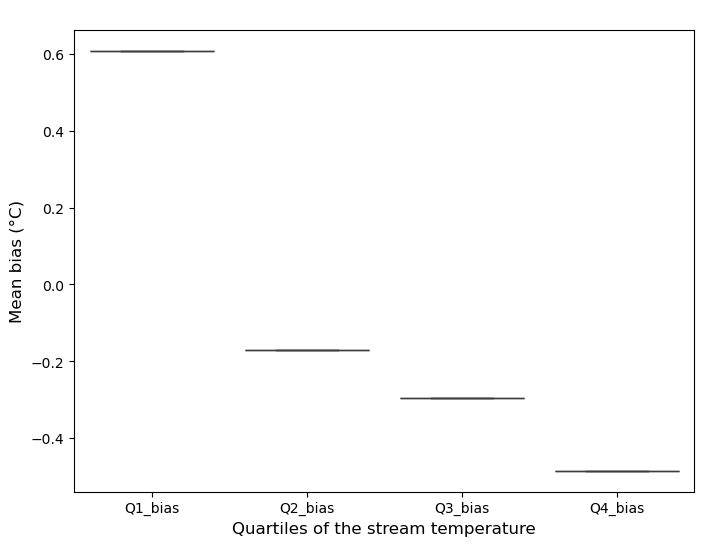

In [16]:
bias_q= bias_q[~ (bias_q['Q1_bias']==0) ]
print(bias_q)
# Create a boxplot of the four bias columns
plt.figure(figsize=(8, 6))
sns.boxplot(data=bias_q[['Q1_bias', 'Q2_bias', 'Q3_bias', 'Q4_bias']])
fontsize = 12
# Add labels and title
plt.title(' ')
plt.xlabel('Quartiles of the stream temperature' , fontsize = fontsize )
plt.ylabel('Mean bias (°C)', fontsize = fontsize)

plt.savefig('bias_q.png')


plt.show()

In [17]:
df1 = bias_q[["site", "Q1_obs", "Q1_bias"]].copy()
df2 = bias_q[["site", "Q2_obs", "Q2_bias"]].copy()
df3 = bias_q[["site", "Q3_obs", "Q3_bias"]].copy()
df4 = bias_q[["site", "Q4_obs", "Q4_bias"]].copy()

df1.columns = ["site", "obs", "bias"]
df2.columns = ["site", "obs", "bias"]
df3.columns = ["site", "obs", "bias"]
df4.columns = ["site", "obs", "bias"]

df_combined = pd.concat([df1, df2,df3,df4], ignore_index=True)



print(df_combined)


       site        obs      bias
0  13092747  15.738889  0.608972
1  13092747  17.414493 -0.171812
2  13092747  18.041892 -0.294973
3  13092747  18.814754 -0.484508


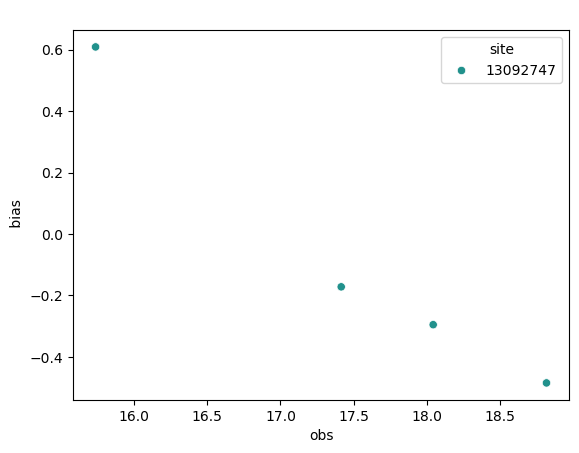

In [18]:


#plt.scatter(df_combined["obs"], df_combined["bias"], hue=df_combined["site"], palette="viridis")

sns.scatterplot(data=df_combined, x="obs", y="bias", hue="site", palette="viridis")

plt.xlabel("obs")
plt.ylabel(" bias")
plt.title(" ")


plt.show()

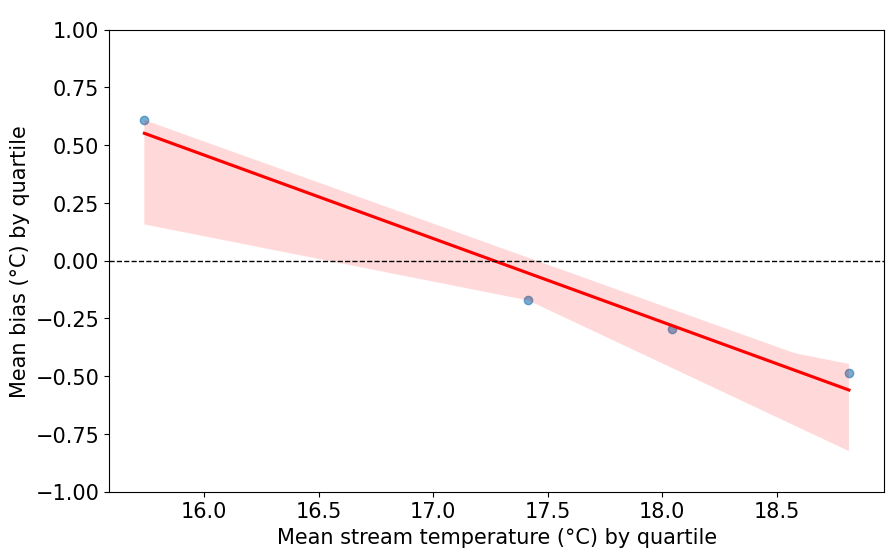

In [19]:

fontsize =15

#sns.set_style("whitegrid")

# Create scatter plot with trend line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_combined, x="obs", y="bias", scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})


# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set y-axis limits
plt.ylim(-1, 1)


plt.xlabel("Observed Values (obs)")
plt.ylabel("Bias")

plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )

plt.xlabel('Mean stream temperature (°C) by quartile' , fontsize = fontsize )
plt.ylabel('Mean bias (°C) by quartile', fontsize = fontsize)

plt.title(" ")

plt.savefig('bias_q_trend.png')

plt.show()


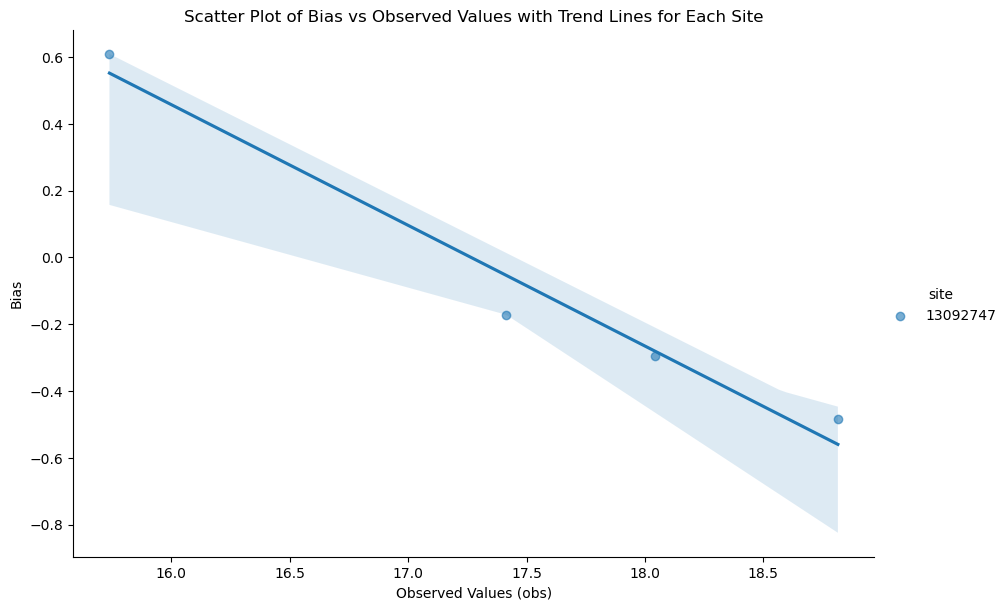

In [20]:
sns.lmplot(data=df_combined, x="obs", y="bias", hue="site", aspect=1.5, height=6, scatter_kws={"alpha": 0.6})

# Labels and title
plt.xlabel("Observed Values (obs)")
plt.ylabel("Bias")
plt.title("Scatter Plot of Bias vs Observed Values with Trend Lines for Each Site")

# Show plot
plt.show()


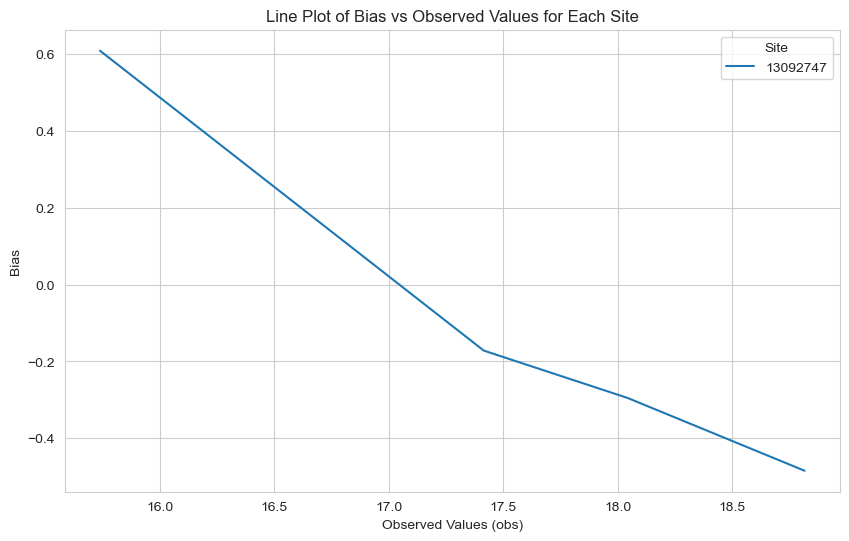

In [21]:
#import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create line plot for each site
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined, x="obs", y="bias", hue="site"
            # , marker="o"
            )

# Labels and title
plt.xlabel("Observed Values (obs)")
plt.ylabel("Bias")
plt.title("Line Plot of Bias vs Observed Values for Each Site")

# Show legend and plot
plt.legend(title="Site")
plt.show()


9. RM SITE = 0 IN THE DF

In [22]:
var=var[var['range']>0 ]

10. merge filtered_df (USGS site info and data) AND evaluate_df

In [23]:
model_df_site = pd.merge(   filtered_df ,  evaluate_df ,left_on = "site_no" , right_on= "site" , how = "inner")    

#print( model_df_site.columns )

model_df_site = model_df_site[[ 'site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va',
        'alt_va',    'number_of_obs'
                               , "grid_r2", 'grid_pseudo_r2' , "grid_mse","grid_bias" , "grid_rmse", "grid_NSE","grid_std_ratio","grid_correlation"
                               #, 'RMS', 'MSE','NSE',
       #'correlation_coefficient', 'mdi_importances_index_0',
      # 'mdi_importances_0', 'mdi_importances_index_1', 'mdi_importances_1'
                              # ,"permutation_0","permutation_importance_0","permutation_1","permutation_importance_1"
                              ]]

print( model_df_site )


    site_no  dec_lat_va  dec_long_va  drain_area_va  alt_va  number_of_obs  \
0  13092747     42.5625  -114.494722            259    3630           1377   

    grid_r2  grid_pseudo_r2  grid_mse  grid_bias  grid_rmse  grid_NSE  \
0  0.683523        0.680032  0.484443  -0.070261   0.696019  0.683523   

   grid_std_ratio  grid_correlation  
0        0.756097          0.832189  


11. Sort the merged DataFrame model_df_site by 'grid_rmse'  

In [24]:



# Sort the DataFrame by 'grid_rmse' in ascending order
sorted_df = model_df_site[['site_no', 'number_of_obs', 'grid_r2', 'grid_pseudo_r2','grid_mse','grid_bias', 'grid_rmse', 'grid_NSE',"grid_std_ratio","grid_correlation"]].sort_values(by='grid_rmse')

print(sorted_df)

#print(sorted_df.columns)

sorted_df.columns = ['site_no', 'number_of_obs', 'r2','pseudo_r2', 'MSE', 'BIAS',       'RMSE', 'NSE',"grid_std_ratio","grid_correlation"]

# Display the sorted DataFrame
print(sorted_df)

# Calculate mean and median for each column
mean_values = sorted_df[[ 'number_of_obs', 'r2', 'pseudo_r2','MSE', 'BIAS',       'RMSE', 'NSE']].mean().transpose()
median_values = sorted_df[[ 'number_of_obs', 'r2', 'pseudo_r2','MSE', 'BIAS',       'RMSE', 'NSE']].median().transpose()

print( mean_values.to_frame().transpose())
# Display the results
print("Mean for each column:\n", mean_values)
print( "mean_values", type(mean_values) )
print("\nMedian for each column:\n", median_values)

    site_no  number_of_obs   grid_r2  grid_pseudo_r2  grid_mse  grid_bias  \
0  13092747           1377  0.683523        0.680032  0.484443  -0.070261   

   grid_rmse  grid_NSE  grid_std_ratio  grid_correlation  
0   0.696019  0.683523        0.756097          0.832189  
    site_no  number_of_obs        r2  pseudo_r2       MSE      BIAS      RMSE  \
0  13092747           1377  0.683523   0.680032  0.484443 -0.070261  0.696019   

        NSE  grid_std_ratio  grid_correlation  
0  0.683523        0.756097          0.832189  
   number_of_obs        r2  pseudo_r2       MSE      BIAS      RMSE       NSE
0         1377.0  0.683523   0.680032  0.484443 -0.070261  0.696019  0.683523
Mean for each column:
 number_of_obs    1377.000000
r2                  0.683523
pseudo_r2           0.680032
MSE                 0.484443
BIAS               -0.070261
RMSE                0.696019
NSE                 0.683523
dtype: float64
mean_values <class 'pandas.core.series.Series'>

Median for each column

12. merge sorted_df and var (variability)

    site_no  number_of_obs        r2  pseudo_r2       MSE      BIAS      RMSE  \
0  13092747           1377  0.683523   0.680032  0.484443 -0.070261  0.696019   

        NSE  grid_std_ratio  grid_correlation  
0  0.683523        0.756097          0.832189  
       site  std_dev_st      cv_q  inter_cv_q  inter_cv_st  range  \
0  13092747    1.206649  0.344015    0.161245     0.024926    9.1   

   autocorr_t_1  autocorr_t_2  
0       0.88218      0.708264  
Empty DataFrame
Columns: [site, std_dev_st, cv_q, inter_cv_q, inter_cv_st, range, autocorr_t_1, autocorr_t_2]
Index: []
    site_no  number_of_obs        r2  pseudo_r2       MSE      BIAS      RMSE  \
0  13092747           1377  0.683523   0.680032  0.484443 -0.070261  0.696019   

        NSE  grid_std_ratio  grid_correlation      site  std_dev_st      cv_q  \
0  0.683523        0.756097          0.832189  13092747    1.206649  0.344015   

   inter_cv_q  inter_cv_st  range  autocorr_t_1  autocorr_t_2  
0    0.161245     0.024926  

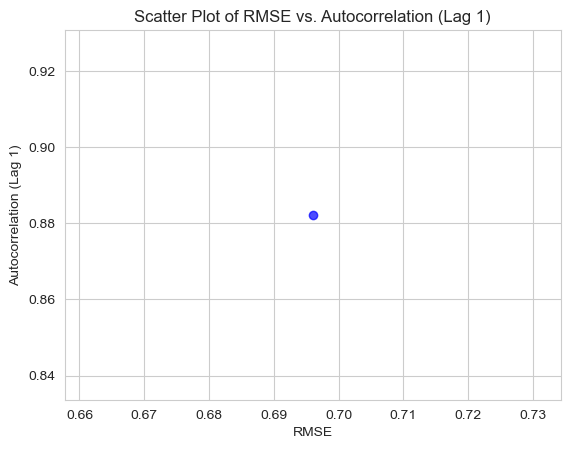

In [25]:
print(sorted_df)
print(var)
print(var[~var['site'].isin(sorted_df['site_no']) ])
sorted_df_var=pd.merge(sorted_df,var,left_on="site_no",right_on="site")
print(sorted_df_var)

# Scatter plot with matplotlib
plt.scatter(sorted_df_var['RMSE'], sorted_df_var['autocorr_t_1'], color='blue', alpha=0.7)
plt.xlabel('RMSE')
plt.ylabel('Autocorrelation (Lag 1)')
plt.title('Scatter Plot of RMSE vs. Autocorrelation (Lag 1)')
plt.grid(True)
plt.show()


13. Interannual variability of discharge shown as coefficient of variation (CV) 

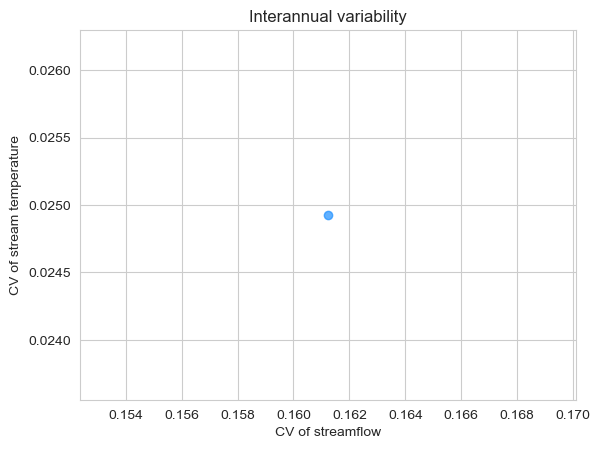

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_9000/3349965478.py:18: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x, y, 1)


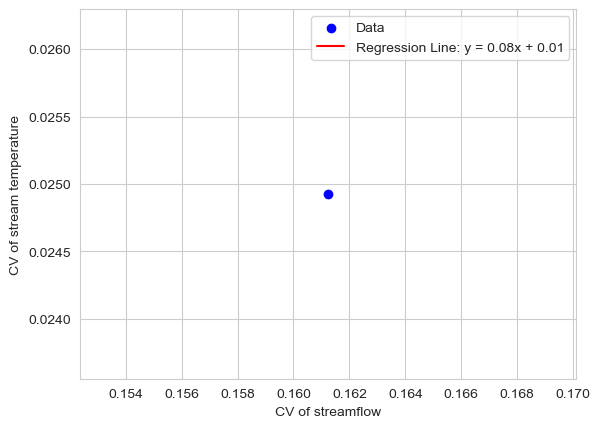

In [26]:
plt.scatter(  sorted_df_var['inter_cv_q'],sorted_df_var['inter_cv_st'], color='dodgerblue', alpha=0.7)
plt.xlabel('CV of streamflow')
plt.ylabel('CV of stream temperature')
plt.title('Interannual variability')
plt.grid(True)
plt.savefig("Interannual_variability.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()



y = sorted_df_var['inter_cv_st']
x = sorted_df_var['inter_cv_q']

# Fit a linear regression model (y = mx + b)
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the regression line
y_pred = slope * x + intercept

# Create the scatter plot
plt.scatter(x, y, label="Data", color="blue")

# Plot the regression line
plt.plot(x, y_pred, color="red", label=f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")

# Add labels and legend
plt.ylabel('CV of stream temperature')
plt.xlabel('CV of streamflow')
plt.legend()

# Show the plot
plt.show()

In [27]:
y = sorted_df_var['inter_cv_st']
x = sorted_df_var['inter_cv_q']

#import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Example data (replace with your actual data)
x = np.array( x).reshape(-1, 1)  # Independent variable
y = np.array( y)  # Dependent variable

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

# Predictions
y_pred = model.predict(x)

# Model accuracy (R-squared)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print the results
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")


Slope: 0.0
Intercept: 0.024925808345921174
R-squared: nan
Mean Squared Error: 0.0000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


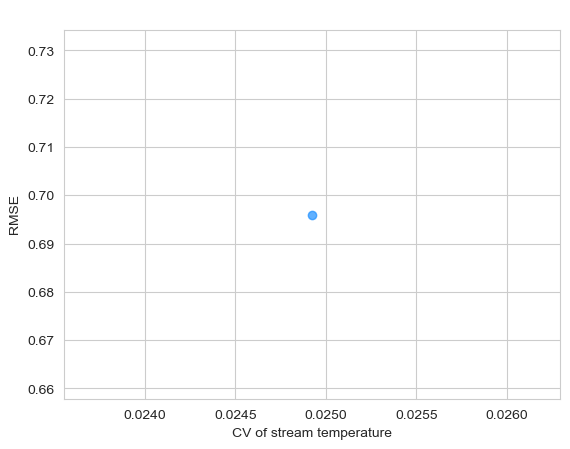

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_9000/888767838.py:18: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x, y, 1)


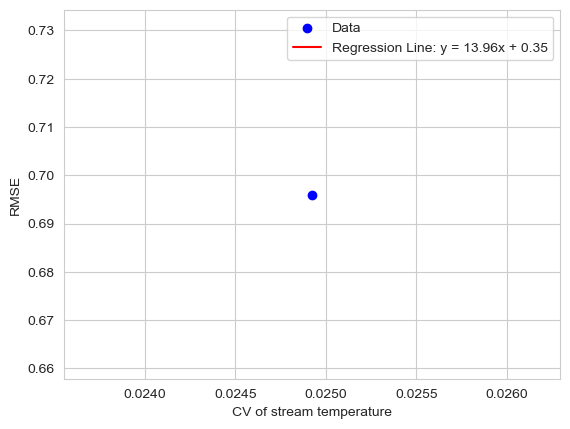

In [28]:
plt.scatter(  sorted_df_var['inter_cv_st'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel(' RMSE ')
plt.xlabel('CV of stream temperature')
plt.title(' ')
plt.grid(True)
plt.savefig("cv_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()

x = sorted_df_var['inter_cv_st']
y = sorted_df_var['RMSE']
#print(x)
#print(y)

# Fit a linear regression model (y = mx + b)
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the regression line
y_pred = slope * x + intercept


# Create the scatter plot
plt.scatter(x, y, label="Data", color="blue")

# Plot the regression line
plt.plot(x, y_pred, color="red", label=f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")

# Add labels and legend
plt.xlabel('CV of stream temperature')
plt.ylabel('RMSE')
plt.legend()

# Show the plot
plt.show()

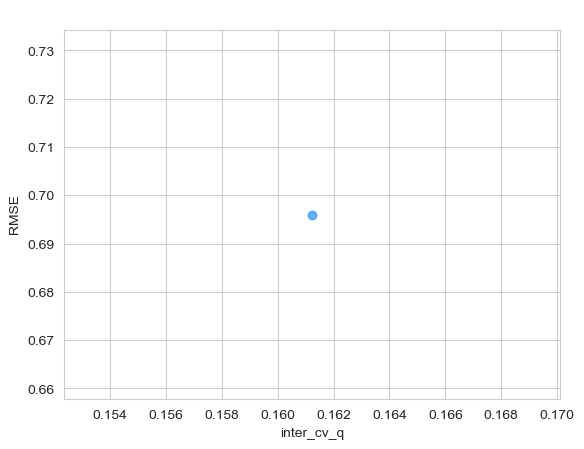

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_9000/2162592756.py:16: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x, y, 1)


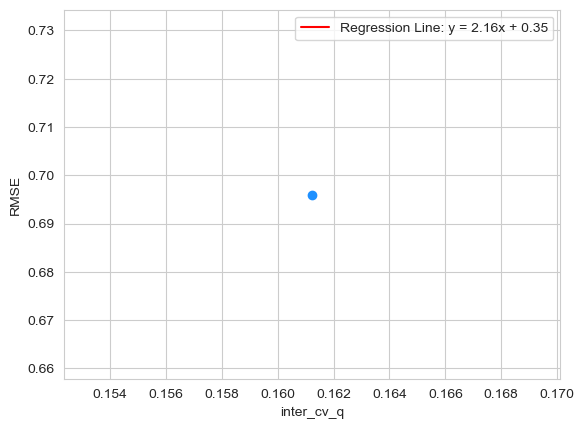

In [29]:
plt.scatter(  sorted_df_var['inter_cv_q'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel(' RMSE ')
plt.xlabel('inter_cv_q')
plt.title(' ')
plt.grid(True)
#plt.savefig("std_dev_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight")  # Save with high resolution
plt.show()

# Assuming sorted_df_var is already defined
x = sorted_df_var['inter_cv_q']
y = sorted_df_var['RMSE']

# Fit a linear regression model (y = mx + b)
slope, intercept = np.polyfit(x, y, 1)

# Generate predicted y values based on the regression line
y_pred = slope * x + intercept

# Create the scatter plot
plt.scatter(x, y
            #, label="Data"
            , color="dodgerblue")

# Plot the regression line
plt.plot(x, y_pred, color="red", label=f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")

# Add labels and legend
plt.xlabel('inter_cv_q')
plt.ylabel('RMSE')
plt.legend()

# Show the plot
plt.show()

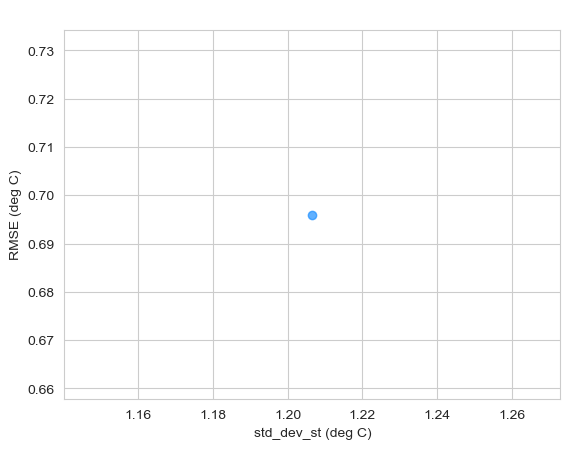

In [30]:


plt.scatter(  sorted_df_var['std_dev_st'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel('RMSE (deg C)')
plt.xlabel('std_dev_st (deg C)')
plt.title(' ')
plt.grid(True)
plt.savefig("std_dev_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()

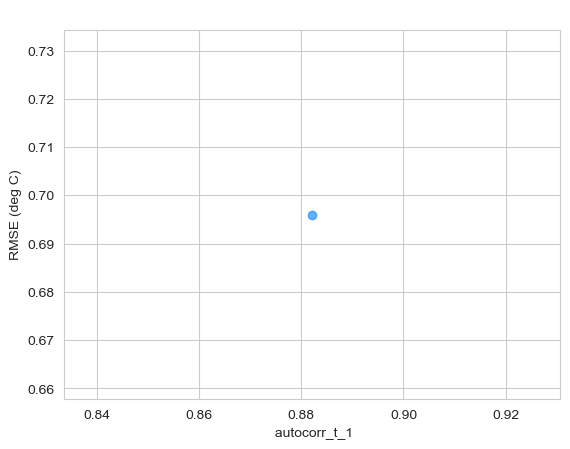

In [31]:



plt.scatter(  sorted_df_var['autocorr_t_1'],sorted_df_var['RMSE'], color='dodgerblue', alpha=0.7)
plt.ylabel('RMSE (deg C)')
plt.xlabel(' autocorr_t_1')
plt.title(' ')
plt.grid(True)
#plt.savefig("std_dev_st_RMSE.png"
            #, dpi=300
           # , bbox_inches="tight"           )  # Save with high resolution
plt.show()


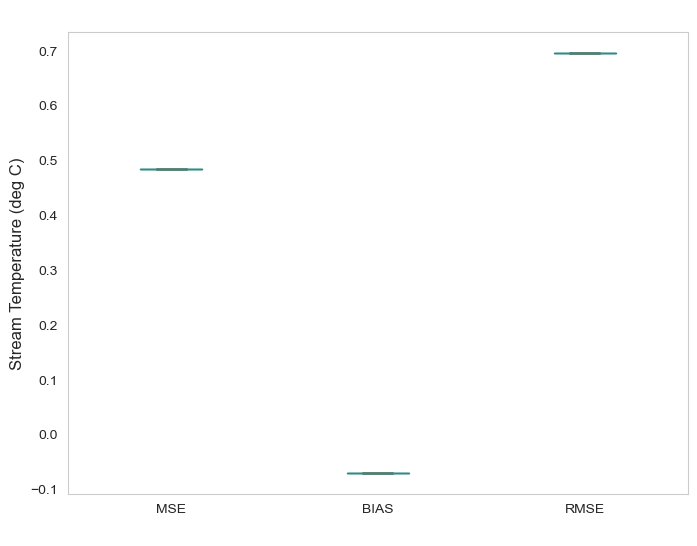

In [32]:
# Plot boxplots for each column
plt.figure(figsize=(8, 6))
sorted_df.boxplot(column=[ 'MSE', 'BIAS','RMSE' ], grid=False)

# Customize plot
plt.title(" ", fontsize=14)
plt.ylabel("Stream Temperature (deg C)", fontsize=12)
plt.xlabel(" ", fontsize=12)
#plt.show()

# Save the plot locally
plt.savefig("box.png"
            #, dpi=300
           # , bbox_inches="tight"
           )  # Save with high resolution
plt.show()

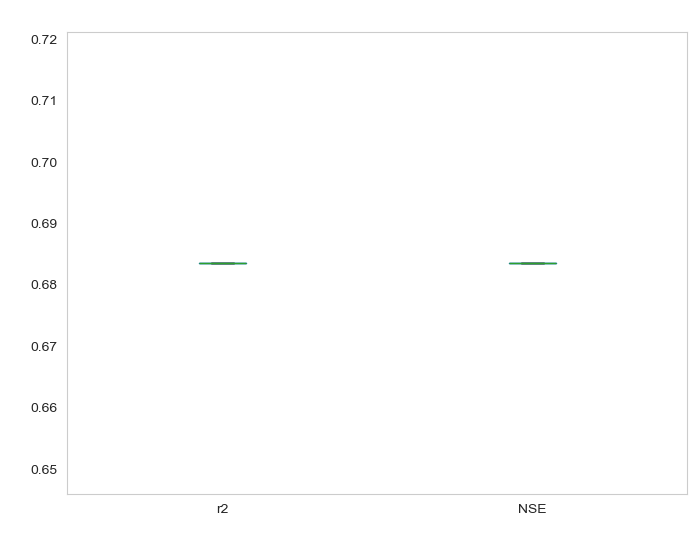

In [33]:
plt.figure(figsize=(8, 6))
sorted_df.boxplot(column=[ 'r2','NSE' ], grid=False)

# Customize plot
plt.title(" ", fontsize=14)
plt.ylabel(" ", fontsize=12)
plt.xlabel(" ", fontsize=12)
#plt.show()

# Save the plot locally
#plt.savefig("box.png")  # Save with high resolution
plt.show()

Index(['site', 'std_dev_st', 'cv_q', 'inter_cv_q', 'inter_cv_st', 'range',
       'autocorr_t_1', 'autocorr_t_2'],
      dtype='object')


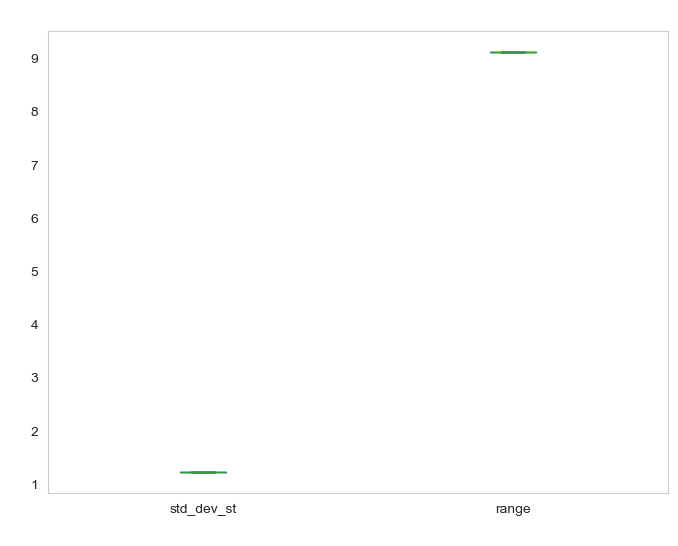

In [34]:
print(var.columns)
plt.figure(figsize=(8, 6))
var.boxplot(column=[  'std_dev_st', 'range'  ], grid=False)


plt.title(" ", fontsize=14)
plt.ylabel(" ", fontsize=12)
plt.xlabel(" ", fontsize=12)


plt.show()

Index(['site', 'std_dev_st', 'cv_q', 'inter_cv_q', 'inter_cv_st', 'range',
       'autocorr_t_1', 'autocorr_t_2'],
      dtype='object')


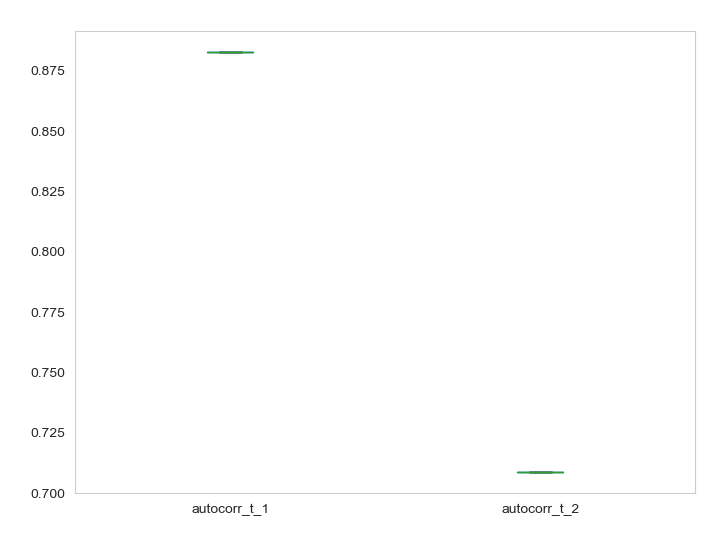

In [35]:
print(var.columns)
plt.figure(figsize=(8, 6))
var.boxplot(column=[    'autocorr_t_1' , 'autocorr_t_2' 
                   # , 'autocorr_t_3'
                   ], grid=False)

plt.title(" ", fontsize=14)
plt.ylabel(" ", fontsize=12)
plt.xlabel(" ", fontsize=12)

plt.show()

save to csv

In [36]:
df_cleaned.to_csv( df_cleaned_csv )
model_df_site.to_csv( model_df_site_csv )
sorted_df[['site_no', 'number_of_obs',   'MSE', 'BIAS',       'RMSE', 'NSE',"grid_std_ratio","grid_correlation"]].to_csv( sorted_df_csv )
sorted_df_var[['site_no', 'number_of_obs',   'MSE', 'BIAS',       'RMSE', 'NSE', "std_dev_st", "cv_q","inter_cv_q","inter_cv_st", "range",  "autocorr_t_1" ,"grid_std_ratio","grid_correlation"  ]].to_csv( sorted_df_var_csv )

In [37]:
df_site_pred_test_0

site_pred_test = df_site_pred_test_0[ df_site_pred_test_0['y_test']>0 ]

print(site_pred_test)

site_pred_test.to_csv(  "site_pred_test.csv" )


          site  y_test  y_pred_best
1101  13092747    15.5       16.079
1102  13092747    12.9       15.697
1103  13092747    14.9       16.356
1104  13092747    15.9       17.393
1105  13092747    15.4       15.959
...        ...     ...          ...
1372  13092747    16.0       16.686
1373  13092747    15.5       15.968
1374  13092747    14.6       15.879
1375  13092747    14.9       16.097
1376  13092747    15.5       16.742

[276 rows x 3 columns]


12.9
19.6
18.893
19.6


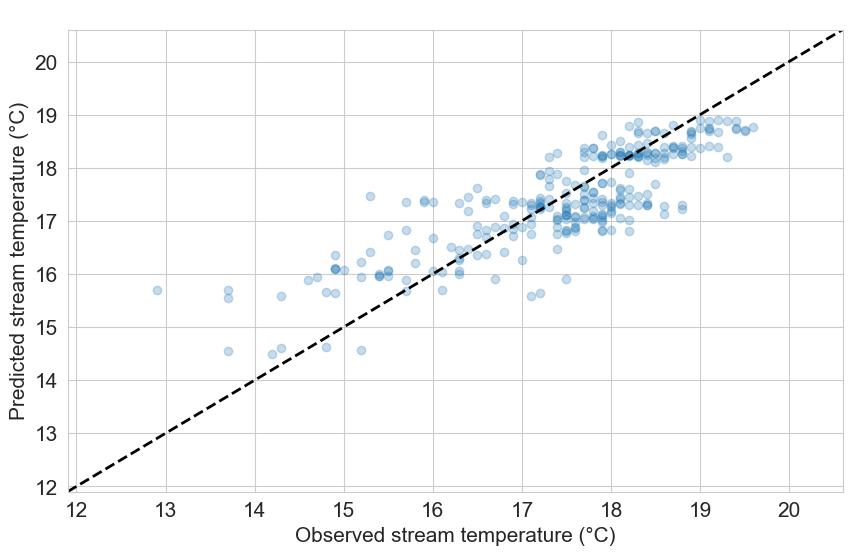

In [38]:
#import matplotlib.pyplot as plt
#import pandas as pd

fontsize =15

min_1= site_pred_test[ 'y_test'].min( )
min_2= site_pred_test['y_pred_best'].min( )
min=np.min([min_1,min_2] )
print(min)

max_1= site_pred_test[ 'y_test'].max( )
print(max_1)
max_2= site_pred_test['y_pred_best'].max( )
print(max_2)
max=np.max([ max_1, max_2] )
print(max)

plt.figure(figsize=(10, 6))
plt.scatter( site_pred_test['y_test'],  site_pred_test['y_pred_best'], alpha=0.25)
plt.plot([ min -1 , max +1 ], [min -1 , max + 1 ], 'k--', lw=2)

plt.ylim( min -1 , max +1)
plt.xlim( min -1 , max +1)

plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )

plt.xlabel('Observed stream temperature (°C)' , fontsize = fontsize )
plt.ylabel('Predicted stream temperature (°C)' , fontsize = fontsize )
plt.title(' ')


plt.savefig('test_pred.png')


plt.show()